In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy
import re 

#plt.style.use('classic')
#plt.style.use('ggplot')

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


# Load and clean data

In [2]:
dZ_raw = np.loadtxt('symmetry-random-pick-dZ.txt')

with open('coronene_energies_2k.txt') as f:
    energy_txt_origin = f.readlines()

with open('coronene_energies_2k_corrected.txt') as f:
    energy_txt_corrected = f.readlines()

In [3]:
#data_cr = np.load('data_coronene_symm.npz')
data_cr = np.load('data_coronene.npz')
ev_data = data_cr['v']
ew_data = data_cr['w']
d1E_data = np.load('data_coronene_1st.npz')
d1E_Z = d1E_data['arr_0']

In [4]:
mol_base = qtk.Molecule()
coord = data_cr['coor'] / qtk.setting.a2b
ZR = np.hstack([data_cr['Z0'][:,np.newaxis], coord])
mol_base.build(ZR)
E0_nuc = mol_base.nuclear_repulsion()

In [5]:
print len(energy_txt_origin), len(energy_txt_corrected), len(dZ_raw)

2145 2137 2137


In [6]:
def extract_log(data_line):
    """extract numbers from each line of the data file
    
       4 numbers are expected: symm_group, mol_ind, E_tot, scf_step
       
       return:
         [symm_group, mol_ind, E_tot] if processed correctly
         np.nan if something wrong
    """
    try:
        ind1, ind2, E, step = [float(e) for e in re.findall(r"[-+]?\d*\.\d+|\d+", data_line)]
        return [ind1, ind2, E]
    except Exception as err:
        print data_line
        print str(err)
        return np.nan
    
def extract_E(data_line):
    try:
        return float(re.findall(r"[-+]?\d*\.\d+", data_line)[0])
    except Exception as err:
        print str(err)
        return np.nan

def extract_name(data_line):
    return data_line.split(':')[0]

In [7]:
# test the regular expression and the processing function
print [float(e) for e in re.findall(r"[-+]?\d*\.\d+|\d+", energy_txt_origin[1])]
print extract_log(energy_txt_origin[0])
print extract_log(energy_txt_origin[1])
print extract_E(energy_txt_origin[0])
print extract_E(energy_txt_origin[1])
print extract_name(energy_txt_origin[0])
print extract_name(energy_txt_origin[1])

########
# NOTE #
########
# first line pure coronene data is in different format (less numbers), therefore returns nan

[2.0, 1.0, -922.478559706, 20.0]
corronene-sp-ccpvdz.log: SCF Done:  E(RPBE-PBE) =  -920.806635315     A.U. after   17 cycles

need more than 2 values to unpack
nan
[2.0, 1.0, -922.478559706]
-920.806635315
-922.478559706
corronene-sp-ccpvdz.log
coronene-random-02-ccpvdz-0000001.log


In [8]:
# extract data, there are nan in some entries
data_all = map(extract_log, energy_txt_origin)
name_all = map(extract_name, energy_txt_origin)

########
# NOTE #
########
# empty line as EOF, no string to process therefore return nan

corronene-sp-ccpvdz.log: SCF Done:  E(RPBE-PBE) =  -920.806635315     A.U. after   17 cycles

need more than 2 values to unpack


need more than 0 values to unpack


In [9]:
############################
# extract data without nan #
############################

data_raw = []
name_raw = []
for i, e in enumerate(data_all):
    try:
        if np.isnan(e):
            print 'nan at index: %d' % i
    except:
        e = deepcopy(e)
        e.append(i)
        data_raw.append(e)
        name_raw.append(name_all[i])
print len(data_raw)

nan at index: 0
nan at index: 2144
2143


In [10]:
##########################
# sort data according to #
#  first:  summ_group    #
#  second: mol_ind       #
# using lexsort function #
##########################
data_raw = np.asarray(data_raw)
ind = np.lexsort((data_raw[:,1], data_raw[:,0]))
data_sorted = data_raw[ind]

######################################################
# find entries with identical symm_group and mol_ind #
######################################################
# identical symm_group gives np.diff(data_sorted[:,0]) == 0
# identical  mol_ind   gives np.diff(data_sorted[:,1]) == 0
diff = np.diff(data_sorted[:,0]) + np.diff(data_sorted[:,1])
# find indices where both symm_group and mol_ind are identical
diff_ind = np.arange(len(diff))[diff == 0] 

In [11]:
#####################################
# construct list of index to delete #
#####################################
ind_to_delete = []
# there are triplet identicals
skip = False # flag for skipping processed index
for i, _ind in enumerate(diff_ind):
    if not skip:
        # most identicals are doublet
        delta = 2
        if i + 1 < len(diff_ind):
            # process triplet identicals
            if diff_ind[i] + 1 == diff_ind[i+1]:
                delta = 3
                skip = True # skip next index
        # identical chunk of molecule data
        chunk = data_sorted[_ind:_ind+delta]
        # get minimum energy
        keep_ind = chunk[np.argmin(chunk[:,2]), 3]
        for ind_tmp in chunk[:, 3]:
            # print data file content
            print energy_txt_origin[int(ind_tmp)],
            # include only larger energies
            if ind_tmp != keep_ind:
                ind_to_delete.append(int(ind_tmp))
    else:
        # only skip once, problematic for quadruplet identicals
        skip = False
print diff_ind
print ind_to_delete

coronene-random-14-ccpvdz-0000121.log: SCF Done:  E(RPBE-PBE) =  -932.292531444     a.u. after   27 cycles
coronene-random-14-ccpvdz-0000121-xqc.log: SCF Done:  E(RPBE-PBE) =  -931.937275995     A.U. after  129 cycles
coronene-random-14-ccpvdz-0000121-xqc.log: SCF Done:  E(RPBE-PBE) =  -932.367785513     a.u. after   45 cycles
coronene-random-16-ccpvdz-0000080.log: SCF Done:  E(RPBE-PBE) =  -933.319942686     A.U. after  129 cycles
coronene-random-16-ccpvdz-0000080.log: SCF Done:  E(RPBE-PBE) =  -933.614356120     a.u. after   25 cycles
coronene-random-16-ccpvdz-0000098.log: SCF Done:  E(RPBE-PBE) =  -934.102854887     A.U. after  129 cycles
coronene-random-16-ccpvdz-0000098.log: SCF Done:  E(RPBE-PBE) =  -934.106631127     a.u. after   73 cycles
coronene-random-16-ccpvdz-0000170.log: SCF Done:  E(RPBE-PBE) =  -934.079436503     A.U. after  129 cycles
coronene-random-16-ccpvdz-0000170.log: SCF Done:  E(RPBE-PBE) =  -934.234951029     a.u. after    6 cycles
coronene-random-16-ccpvdz-000

In [12]:
#########################################
# additional entires in dZ file:        #
# coronene-random-24-ccpvdz-0000035.log #
# coronene-random-24-ccpvdz-0000055.log #
#########################################

ind_dZ_delete = []
for s, i, E, j in data_raw:
    if int(s) == 24:
        if int(i) == 34:
            print s, i, j
            ind_dZ_delete.append(int(j))
        elif int(i) == 54:
            print s, i, j
            ind_dZ_delete.append(int(j+1))
print ind_dZ_delete

24.0 34.0 2078.0
24.0 54.0 2097.0
[2078, 2098]


In [13]:
mask = np.ones(len(dZ_raw), dtype=bool)
mask[ind_dZ_delete] = False
dZ = dZ_raw[mask] 

In [14]:
data = []
name = []
for i in data_raw[:,-1].astype(int) - 1:
    if i not in ind_to_delete:
        data.append(data_raw[i])
        name.append(name_raw[i])
    else:
        print 'skip: %s' % data_raw[i]
data = np.asarray(data)
name = np.array(name)

# mask = np.ones(len(data_raw), dtype=bool)
# mask[ind_to_delete] = False
# data = data_raw[mask]

print data.shape
print name.shape

skip: [  14.        121.       -931.937276 1102.      ]
skip: [  14.          121.         -932.36778551 1103.        ]
skip: [  16.           80.         -933.61435612 1374.        ]
skip: [  16.           98.         -934.10663113 1393.        ]
skip: [  16.          170.         -934.23495103 1466.        ]
skip: [  16.          204.         -933.74951709 1501.        ]
skip: [  18.           12.         -935.47547277 1601.        ]
skip: [  18.          170.         -935.84670022 1760.        ]
(2135, 4)
(2135,)


# dZ check

(2065, 2100)

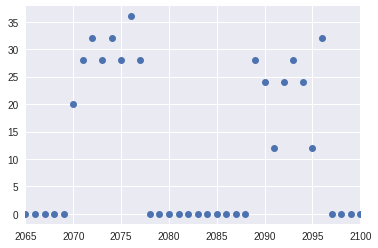

In [15]:
mol_check = []
for n in name:
    out = qtk.QMOut('g09_output/%s' % n, program='gaussian')
    mol = out.molecule
    mol.rotate(np.pi/2., [0,1,0])
    mol.rotate(-np.pi/2., [0,0,1])
    mol_check.append(mol)

dZ_check = np.vstack([(m.Z - mol_base.Z)[:24] for m in mol_check])

plt.plot(abs(dZ_check - dZ).sum(1), ls='', marker='o')
plt.xlim(2065, 2100)

In [16]:
dZ_original = dZ

In [17]:
print data.shape, dZ_original.shape, dZ_check.shape

(2135, 4) (2135, 24) (2135, 24)


In [18]:
E0_tot = extract_E(energy_txt_origin[0])

In [19]:
E_tot = data[:,2]

# load eigen data for energy estimate

In [20]:
dZ = deepcopy(dZ_check)

In [21]:
E_nuc = []
for dz in dZ:
    coor = deepcopy(data_cr['coor'] / qtk.setting.a2b)
    Z = np.array(data_cr['Z0']).astype('float64')
    Z[:len(dz)] += dz
    mol = qtk.Molecule()
    ZR = np.hstack([Z[:,np.newaxis], coor])
    mol.build(ZR)
    E_nuc.append(mol.nuclear_repulsion())
E_nuc = np.array(E_nuc)

In [22]:
A_ref = {
    'C': -37.78852730974084,
    'B': -23.78911314264996,
    'N': -53.48097646532363,
    'H': -0.4986274134174679,
}

In [23]:
dZs = abs(dZ).sum(1) / 2
E_atoms = 12 * A_ref['H'] + (24 - 2*dZs) * A_ref['C'] + dZs * (A_ref['B'] + A_ref['N']) 

In [24]:
E_nuc

array([1820.15725045, 1819.97262159, 1820.12868911, ..., 1817.66676672,
       1818.73669474, 1816.56954238])

In [25]:
E_ele = E_tot - E_nuc
E0_ele = E0_tot - E0_nuc
dE_nuc = E_nuc - E0_nuc

In [26]:
def energy_estimate(dZ):
    # normal mode decomposition
    dZes = dZ.dot(ev_data) # np.dot(dZ, ev_data)
    # calculate first/second order estimate
    d1E = dZ.dot(d1E_Z)
    d2E = (dZes ** 2).dot(ew_data) * 0.5
    return E0_ele + d1E + d2E

In [27]:
E_prd = energy_estimate(dZ)

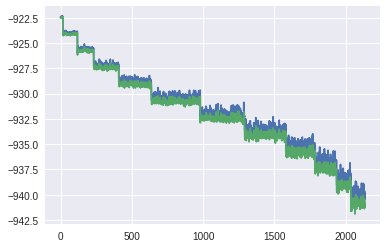

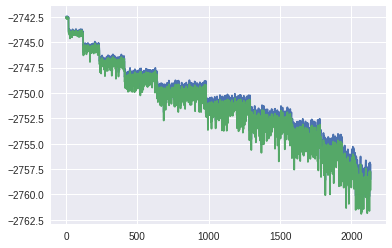

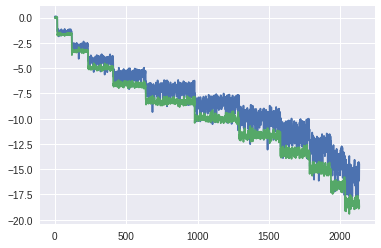

In [28]:
plt.plot(E_prd + E_nuc)
plt.plot(E_tot)
plt.figure()
plt.plot(E_prd)
plt.plot(E_tot - E_nuc)
plt.figure()
plt.plot(E_prd - E_prd[0])
plt.plot(E_tot - E_tot[0])

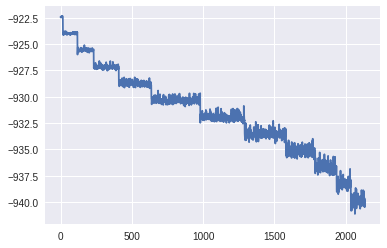

In [29]:
plt.plot(E_prd + E_nuc)

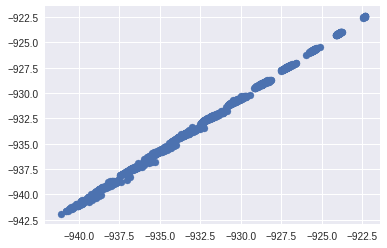

In [30]:
plt.scatter(E_prd + E_nuc, E_tot)

# save processed data to text file

In [49]:
E_prd_ele = E_prd - E0_ele

In [50]:
E_nuc

array([1820.15725045, 1819.97262159, 1820.12868911, ..., 1817.66676672,
       1818.73669474, 1816.56954238])

In [54]:
E_tar_ele = E_ele - E0_ele

In [55]:
E_prd_ele - E_tar_ele

array([0.06739385, 0.06386697, 0.06566128, ..., 0.92538452, 1.02520277,
       0.77629197])

In [65]:
dE_data = np.vstack([E_prd_ele, E_nuc, E_tar_ele]).T
np.savetxt('coronene-dE-2k.txt', dE_data)

In [68]:
dE_data.shape

(2135, 3)

In [70]:
np.savetxt('coronene-dZ-2k.txt', dZ, fmt='%.1f')

# pandas analysis

In [31]:
E_tot_fit, fit_coeff = qtk.ML.l2_fit(E_prd + E_nuc, E_tot, get_coefficents=True)

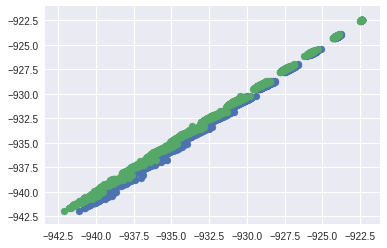

In [32]:
plt.scatter(E_prd + E_nuc, E_tot)
plt.scatter(E_tot_fit, E_tot)

In [33]:
qtk.ML.l2_fit(E_tot, E_prd + E_nuc, get_coefficents=True)

(array([-922.43433675, -922.49454555, -922.4366262 , ..., -940.0045138 ,
        -939.90900404, -940.27716015]), array([-45.15871958,   0.95099838]))

In [34]:
fit_coeff

array([46.89451564,  1.05089207])

In [35]:
df.Et_tar

NameError: name 'df' is not defined

In [36]:
data = np.stack([
    name,                      #0
    abs(dZ).sum(1)/2.,         #1
    # target properties
    E_tot,                     #2
    E_tot - E_nuc,             #3
    E_tot - E0_tot,            #4
    E_tot - E_nuc - E0_ele,    #5
    E_tot - E_atoms,           #6
    # prediected properties
    E_prd + E_nuc,             #7
    E_prd,                     #8
    E_prd + E_nuc - E0_tot,    #9
    E_prd - E0_ele,            #10
    E_prd + E_nuc - E_atoms,   #11
    # nuclear repulsion
    E_nuc,                     #12
]).T
column_names = [
    'name',     #0
    'BN_pairs', #1
    'Et_tar',   #2
    'Ee_tar',   #3
    'dEt_tar',  #4
    'dEe_tar',  #5
    'Ea_tar',   #7
    'Et_prd',   #7
    'Ee_prd',   #8
    'dEt_prd',  #9
    'dEe_prd',  #10
    'Ea_prd',   #11
    'E_nuc',    #12
]
df = pd.DataFrame(data, columns=column_names)
for cn in column_names:
    if cn != 'name':
        df[cn] = df[cn].astype('float')

df['id'] = np.arange(len(dZ))
# # rescale
df['Et_rsp'] = df.Et_prd * fit_coeff[1] + fit_coeff[0]
df['Ee_rsp'] = df.Et_rsp - df.E_nuc
df['Ea_rsp'] = df.Et_rsp - E_atoms
# error
df['Et_err'] = df.Et_tar - df.Et_prd
df['Et_err_norm'] = (df.Et_tar - df.Et_prd) / df.BN_pairs
df['Et_tar_norm'] = df.Et_tar / df.BN_pairs
df['Et_prd_norm'] = df.Et_prd / df.BN_pairs
df['Ee_err'] = df.Ee_tar - df.Ee_prd
df['Ee_err_norm'] = (df.Ee_tar - df.Ee_prd) / df.BN_pairs
df['Ee_tar_norm'] = df.Ee_tar / df.BN_pairs
df['Ee_prd_norm'] = df.Ee_prd / df.BN_pairs
df['Ea_rsp_norm'] = (df.Ea_tar - df.Ea_rsp) / df.BN_pairs

# identical results
# df['Ee_err'] = df.Ee_tar - df.Ee_prd
# df['Ee_err_norm'] = (df.Ee_tar - df.Ee_prd) / df.BN_pairs
df_sort_Et = df.sort_values('Et_tar')
df_sort_Et_norm = df.sort_values('Et_tar_norm')
df_sort_Ee_norm = df.sort_values('Ee_tar_norm')
df_sort_Ea = df.sort_values('Ea_tar')

for df_tmp in [df, df_sort_Et, df_sort_Et_norm, df_sort_Ee_norm, df_sort_Ea]:
    df_tmp['ind'] = np.arange(len(dZ))

In [37]:
df.Et_prd.as_matrix()

array([-922.41116586, -922.47800389, -922.41530585, ..., -940.02868197,
       -939.82843268, -940.46446939])

In [38]:
df_sort_Ea.id.head()

2064    2064
1506    1506
2041    2041
2036    2036
1947    1947
Name: id, dtype: int64

In [39]:
df_sort_Ea.ind.head()

2064    0
1506    1
2041    2
2036    3
1947    4
Name: ind, dtype: int64

/home/samio/local/miniconda2/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/home/samio/local/miniconda2/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


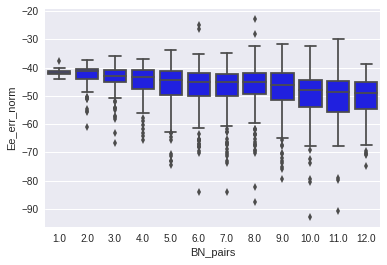

In [40]:
#sns.violinplot(df.err_normalized * qtk.convE(1, 'Ha-kcal')[0], groupby=df.N, color='0.8')
sns.boxplot(df.Ee_err_norm * qtk.convE(1, 'Ha-kcal')[0], groupby=df.BN_pairs, color='b')

#sns.violinplot(abs(df.E - df.E_prd), groupby=df.N)

In [41]:
df.describe()

,BN_pairs,Et_tar,Ee_tar,dEt_tar,dEe_tar,Ea_tar,Et_prd,Ee_prd,dEt_prd,dEe_prd,...,Et_err,Et_err_norm,Et_tar_norm,Et_prd_norm,Ee_err,Ee_err_norm,Ee_tar_norm,Ee_prd_norm,Ea_rsp_norm,ind
count,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,...,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000
mean,6.835597,-932.185158,-2751.387819,-11.378523,-10.239294,-7.704069,-931.665296,-2750.867957,-10.858661,-9.719432,...,-0.519862,-0.074871,-169.253558,-169.178687,-0.519862,-0.074871,-500.395921,-500.321050,0.000009,1067.000000
std,2.588571,4.333252,3.962826,4.333252,3.962826,0.246094,4.122159,3.737002,4.122159,3.737002,...,0.235242,0.012103,110.113056,110.115615,0.235242,0.012103,327.801912,327.804466,0.013589,616.465733
min,1.000000,-941.900778,-2761.924193,-21.094143,-20.775668,-8.676174,-941.126220,-2760.588690,-20.319585,-19.440165,...,-1.590443,-0.148013,-922.541871,-922.478004,-1.590443,-0.148013,-2742.704376,-2742.633941,-0.077583,0.000000
25%,5.000000,-935.391892,-2753.988062,-14.585257,-12.839538,-7.863389,-934.565525,-2753.377259,-13.758890,-12.228735,...,-0.652354,-0.080008,-185.821636,-185.746618,-0.652354,-0.080008,-549.698733,-549.627175,-0.005898,533.500000
50%,7.000000,-932.336648,-2751.263179,-11.530013,-10.114655,-7.738836,-931.794363,-2750.774929,-10.987728,-9.626404,...,-0.495415,-0.071832,-133.227916,-133.158588,-0.495415,-0.071832,-393.118111,-393.042896,0.002806,1067.000000
75%,9.000000,-929.142021,-2748.635789,-8.335386,-7.487265,-7.569694,-928.792345,-2748.261289,-7.985709,-7.112764,...,-0.359256,-0.066658,-104.024841,-103.959489,-0.359256,-0.066658,-306.219917,-306.117154,0.009443,1600.500000
max,12.000000,-922.426935,-2742.493458,-1.620300,-1.344934,-6.717496,-922.359749,-2742.433403,-1.553114,-1.284879,...,-0.060055,-0.036489,-78.334404,-78.221774,-0.060055,-0.036489,-229.752928,-229.688382,0.037163,2134.000000


(-30, 30)

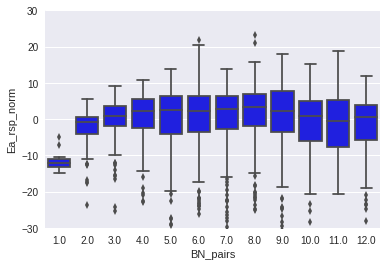

In [42]:
sns.boxplot(df.Ea_rsp_norm * qtk.convE(1, 'Ha-kcal')[0], groupby=df.BN_pairs, color='b')
plt.ylim(-30,30)

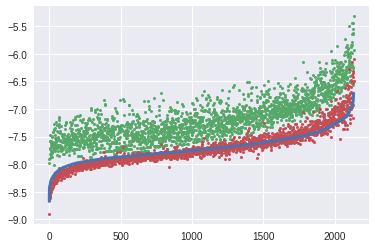

In [43]:
plt.plot(df_sort_Ea.Ea_tar.as_matrix(), lw=3)
plt.plot(df_sort_Ea.Ea_prd.as_matrix(), ls='', marker='o', zorder=1, ms=3)
plt.plot(df_sort_Ea.Ea_rsp.as_matrix(), ls='', marker='o', zorder=1, ms=3)

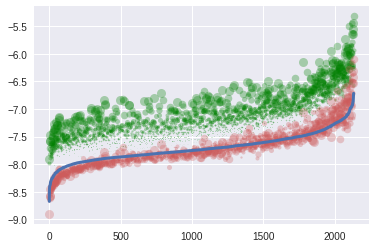

In [44]:
plt.plot(df_sort_Ea.Ea_tar.as_matrix(), lw=3, zorder=10)
for key,grp in df_sort_Ea.groupby('BN_pairs'):
    plt.plot(grp.ind, grp.Ea_prd.as_matrix(), ls='', color='g', marker='o', ms=key**2 / 4.**2, alpha=0.3, zorder=1)
    plt.plot(grp.ind, grp.Ea_rsp.as_matrix(), ls='', color='indianred', marker='o', ms=key**2 / 4.**2, alpha=0.3, zorder=2)

# visualize outliers

In [43]:
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display, HTML

import os

In [44]:
def mol2svg(mol,
             molSize=(200,200),
             kekulize=False, 
             index=False,
             atom_label=False,
             highlight=[],
             colors={},
             sizes={},
            ):
    
    #drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1], int(.5*molSize[0]), int(molSize[1]*.5))
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    opts = drawer.drawOptions()
    kw_drawing = {}
    
    ##################
    # bare bone plot #
    ##################
    m = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(m)
        except:
            m = Chem.Mol(mol.ToBinary())
    if not m.GetNumConformers():
        rdDepictor.Compute2DCoords(m)
    
    ############
    # indexing #
    ############
    if index:
        for i in range(m.GetNumAtoms()):
            opts.atomLabels[i] = m.GetAtomWithIdx(i).GetSymbol()+str(i)
            
    ##############
    # atom label #
    ##############
    if atom_label:
        for i in range(m.GetNumAtoms()):
            opts.atomLabels[i] = m.GetAtomWithIdx(i).GetSymbol()
        
    #################
    # high lighting #
    #################
    kw_hl = {
        'highlightAtoms': highlight,
        'highlightAtomColors': colors,
        'highlightAtomRadii': sizes,
        'highlightBonds': None,
    }
    kw_drawing.update(kw_hl)
    
    drawer.DrawMolecule(m, **kw_drawing)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

In [45]:
def rdmol2svglist(m, data):
    svg_list = []
    for i in range(len(data['w'])):
        v = data['v'][:,i]
        w = data['w'][i]
        color = {}
        sizes = {}
        highlight = []
        for j in range(len(data['w'])):
            highlight.append(j)
            sizes[j] = v[j]
            if v[j] != 0:
                if v[j] > 0:
                    color[j] = tuple(192./255 for _ in range(3))
                elif v[j] < 0:
                    color[j] = tuple(.2 for _ in range(3))
        kw_bz1 = {
            'molSize': (400,400),
            'index': False,
            # highlights
            'highlight': highlight,
            'colors': color,
            'sizes': sizes
        }
        svg_list.append(mol2svg(m, **kw_bz1))
    return svg_list

In [46]:
def svg2file(svgs, name):
    for i, s in enumerate(svgs):
        with open('%s_ev_%02d.svg' % (name, i), 'w') as f:
            f.write(s)

In [47]:
mol_base = qtk.Molecule('coronene.xyz')
def getMol(dZ):
    mol = qtk.Molecule()
    R = mol_base.R
    Z = np.array(mol_base.Z)
    Z[:len(dZ)] = Z[:len(dZ)] + np.array(dZ)
    ZR = np.hstack([Z[:,np.newaxis], R])
    mol.build(ZR)
    return mol

In [48]:
def inds2mols(inds):
    mols = []
    for i in inds:
        mol = getMol(dZ[i])
        mol.name = df.name[i].split('.')[0] + ' Et=%f' % df.Et_tar[i]
        mols.append(mol)
    return mols

In [50]:
def mols2svgs(mol_list):
    rdm_list = []
    for mol in mol_list:
        mol.write('tmp.xyz')
        os.system("obabel -ixyz -opdb tmp.xyz > tmp.pdb")
        rdm_list.append(Chem.MolFromPDBFile('tmp.pdb'))
    svg_list = []
    for i, mol in enumerate(mol_list):
        B_list = np.arange(mol.N)[mol.Z == 5].tolist()
        svg = mol2svg(rdm_list[i], index=True, highlight=B_list)
        svg_list.append(svg)
    return svg_list

In [51]:
def inds2g09mols(inds):
    mol_check = []
    out_check = []
    for n in df.name[inds]:
        out = qtk.QMOut('g09_output/%s' % n, program='gaussian')
        mol = out.molecule
        mol.rotate(np.pi/2., [0,1,0])
        mol.rotate(-np.pi/2., [0,0,1])
        mol_check.append(mol)
        out_check.append(out)
    return mol_check, out_check

In [52]:
def check_inds(svg_list, svg_check_list, inds):
    no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
    for i, svg_check in enumerate(svg_check_list):
        svg = svg_list[i]
        print inds[i], df.name[inds[i]], df.Et_tar[inds[i]], (df.Ea_prd - df.Ea_tar)[inds[i]]
        display(HTML(no_wrap_div.format(svg, svg_check)))

## Identify outlies Ea

In [53]:
err_abs_ind = df.id.where(abs(df.Ea_prd - df.Ea_tar) > 1.45).dropna().as_matrix().astype(int)
print err_abs_ind

[1817 1963]


In [54]:
mol_err_abs = inds2mols(err_abs_ind)
svg_err_abs = mols2svgs(mol_err_abs)
mol_err_abs_check, out_err_abs_check = inds2g09mols(err_abs_ind)
svg_err_abs_check = mols2svgs(mol_err_abs_check)

In [55]:
check_inds(svg_err_abs, svg_err_abs_check, err_abs_ind)

1817 coronene-random-20-ccpvdz-0000032.log -936.769631303 1.4801313018828068


1963 coronene-random-22-ccpvdz-0000028.log -938.611607813 1.590442855432343


## Identify outliers rescaled Ea

In [56]:
err_ind = df.id.where(abs(df.Ea_rsp - df.Ea_tar) > 0.6).dropna().as_matrix().astype(int)
print err_ind

[1817 1963 2030]


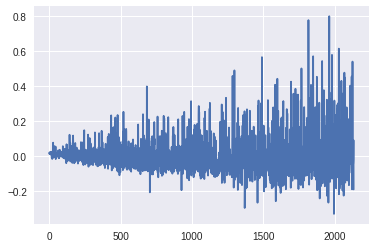

In [57]:
plt.plot(df.Ea_rsp - df.Ea_tar)

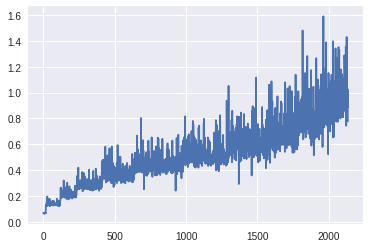

In [58]:
plt.plot(df.Ea_prd - df.Ea_tar)

In [532]:
dZ[err_ind]

array([[-1.,  1.,  1.,  0.,  0., -1.,  0., -1.,  1.,  1.,  0., -1., -1.,
         0.,  0.,  1.,  0.,  1.,  1.,  1., -1., -1.,  0., -1.],
       [-1., -1.,  1.,  1., -1.,  1., -1.,  0.,  1.,  0.,  0.,  0., -1.,
        -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
       [ 1.,  0.,  0., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,
         1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
        -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.]])

In [533]:
df[['name', 'Et_tar', 'Et_prd', 'Et_rsp', 'Ea_tar', 'Ea_rsp', 'Ea_rsp_norm']].ix[err_ind]

,name,Et_tar,Et_prd,Et_rsp,Ea_tar,Ea_rsp,Ea_rsp_norm
1491,coronene-random-16-ccpvdz-0000201.log,-933.402739,-932.286825,-932.838943,-6.950275,-6.386479,-0.070475
1817,coronene-random-20-ccpvdz-0000032.log,-936.769631,-935.289500,-935.994892,-6.931097,-6.156358,-0.077474
1963,coronene-random-22-ccpvdz-0000028.log,-938.611608,-937.021165,-937.814951,-7.080039,-6.283382,-0.072423
2070,coronene-random-24-ccpvdz-0000036.log,-940.624004,-938.670853,-939.548849,-7.399399,-6.324244,-0.089596
2075,coronene-random-24-ccpvdz-0000041.log,-941.419640,-938.772607,-939.655797,-8.195036,-6.431192,-0.146987


In [534]:
i = 2071
df_check[['file name 1', 'E_tot', 'E_predic']].ix[i-2:i+2]

,file name 1,E_tot,E_predic
2069.0,coronene-random-24-ccpvdz-0000032.log:,-940.618247,-940.589126
2070.0,coronene-random-24-ccpvdz-0000033.log:,-940.899583,-940.626486
2071.0,coronene-random-24-ccpvdz-0000034.log:,-940.012843,-939.599534
2072.0,coronene-random-24-ccpvdz-0000036.log:,-940.624004,-940.412242
2073.0,coronene-random-24-ccpvdz-0000037.log:,-941.214196,-941.147432


In [584]:
df.name[err_ind]

1491    coronene-random-16-ccpvdz-0000201.log
1817    coronene-random-20-ccpvdz-0000032.log
1963    coronene-random-22-ccpvdz-0000028.log
2070    coronene-random-24-ccpvdz-0000036.log
2075    coronene-random-24-ccpvdz-0000041.log
Name: name, dtype: object

In [535]:
mol_outliers = inds2mols(err_ind)
svg_outliers = mols2svgs(mol_outliers)

coronene-random-16-ccpvdz-0000201 Et=-933.402739


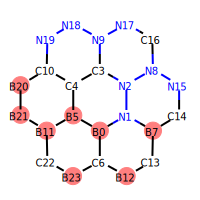

coronene-random-20-ccpvdz-0000032 Et=-936.769631


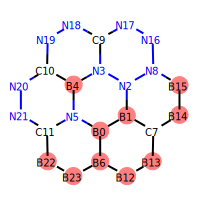

coronene-random-22-ccpvdz-0000028 Et=-938.611608


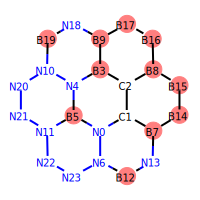

coronene-random-24-ccpvdz-0000036 Et=-940.624004


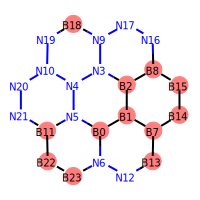

coronene-random-24-ccpvdz-0000041 Et=-941.419640


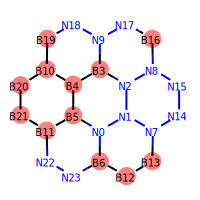

In [537]:
for i, svg in enumerate(svg_outliers):
    print mol_outliers[i].name
    display(SVG(svg))
#     with open('opt_mol_%02d.svg' % i, 'w') as f:
#         f.write(svg)

## Check large BN number with small error

In [523]:
df_BN12 = df.where(df.BN_pairs == 12).dropna()
s_Ea_BN12 = df_BN12.Ea_rsp_norm
good_ind = df_BN12.id.where(abs(s_Ea) < 0.001).dropna().as_matrix().astype(int)
print good_ind

[2066 2109 2113 2116 2117 2128]


In [524]:
df.ix[good_ind]

,name,BN_pairs,Et_tar,Ee_tar,dEt_tar,dEe_tar,Ea_tar,Et_prd,Ee_prd,dEt_prd,...,Et_err,Et_err_norm,Et_tar_norm,Et_prd_norm,Ee_err,Ee_err_norm,Ee_tar_norm,Ee_prd_norm,Ea_rsp_norm,ind
2066,coronene-random-24-ccpvdz-0000031.log,12.0,-941.164368,-2758.781020,-20.357733,-17.632496,-7.939764,-940.201615,-2757.818267,-19.394980,...,-0.962753,-0.080229,-78.430364,-78.350135,-0.962753,-0.080229,-229.898418,-229.818189,-0.000552,2066
2109,coronene-random-24-ccpvdz-0000076.log,12.0,-940.971374,-2758.344694,-20.164739,-17.196170,-7.746770,-940.033502,-2757.406822,-19.226867,...,-0.937872,-0.078156,-78.414281,-78.336125,-0.937872,-0.078156,-229.862058,-229.783902,0.000807,2109
2113,coronene-random-24-ccpvdz-0000080.log,12.0,-941.333818,-2758.326099,-20.527182,-17.177575,-8.109213,-940.364509,-2757.356790,-19.557873,...,-0.969309,-0.080776,-78.444485,-78.363709,-0.969309,-0.080776,-229.860508,-229.779733,-0.000405,2113
2116,coronene-random-24-ccpvdz-0000083.log,12.0,-941.121717,-2758.306007,-20.315081,-17.157483,-7.897112,-940.160823,-2757.345113,-19.354187,...,-0.960894,-0.080074,-78.426810,-78.346735,-0.960894,-0.080074,-229.858834,-229.778759,-0.000570,2116
2117,coronene-random-24-ccpvdz-0000084.log,12.0,-940.866058,-2759.071031,-20.059423,-17.922506,-7.641454,-939.929356,-2758.134329,-19.122721,...,-0.936702,-0.078058,-78.405505,-78.327446,-0.936702,-0.078058,-229.922586,-229.844527,0.000461,2117
2128,coronene-random-24-ccpvdz-0000095.log,12.0,-940.839941,-2759.053571,-20.033306,-17.905047,-7.615337,-939.895536,-2758.109166,-19.088901,...,-0.944405,-0.078700,-78.403328,-78.324628,-0.944405,-0.078700,-229.921131,-229.842431,-0.000325,2128


In [526]:
mol_BN12_good = inds2mols(good_ind)
svg_good = mols2svgs(mol_BN12_good)

In [527]:
mol_BN12_good

[coronene-random-24-ccpvdz-0000031 Et=-941.164368,
 coronene-random-24-ccpvdz-0000076 Et=-940.971374,
 coronene-random-24-ccpvdz-0000080 Et=-941.333818,
 coronene-random-24-ccpvdz-0000083 Et=-941.121717,
 coronene-random-24-ccpvdz-0000084 Et=-940.866058,
 coronene-random-24-ccpvdz-0000095 Et=-940.839941]

coronene-random-24-ccpvdz-0000031 Et=-941.164368


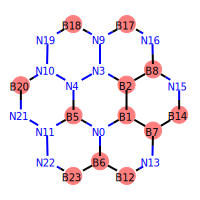

coronene-random-24-ccpvdz-0000076 Et=-940.971374


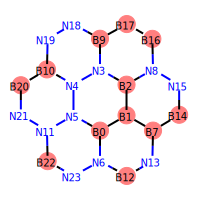

coronene-random-24-ccpvdz-0000080 Et=-941.333818


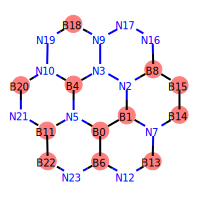

coronene-random-24-ccpvdz-0000083 Et=-941.121717


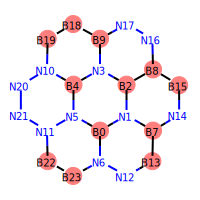

coronene-random-24-ccpvdz-0000084 Et=-940.866058


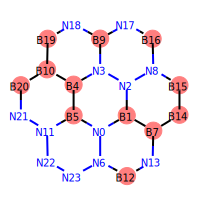

coronene-random-24-ccpvdz-0000095 Et=-940.839941


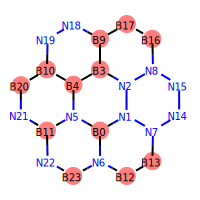

In [538]:
for i, svg in enumerate(svg_good):
    print mol_BN12_good[i].name
    display(SVG(svg))

In [577]:
mol_good_check = []
out_good_check = []
for n in df.name[good_ind]:
    out = qtk.QMOut('g09_output/%s' % n, program='gaussian')
    mol = out.molecule
    mol.rotate(np.pi/2., [0,1,0])
    mol.rotate(-np.pi/2., [0,0,1])
    mol_good_check.append(mol)
    out_good_check.append(out)

In [578]:
svg_good_check = mols2svgs(mol_good_check)

In [579]:
mol_good_check[0]

H12B12N12

In [580]:
no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
for i, svg_check in enumerate(svg_good_check):
    svg = svg_good[i]
    print df.name[good_ind[i]], out_good_check[i].Et
    display(HTML(no_wrap_div.format(svg, svg_check)))

coronene-random-24-ccpvdz-0000031.log -941.1643684


coronene-random-24-ccpvdz-0000076.log -940.9713743


coronene-random-24-ccpvdz-0000080.log -941.3338177


coronene-random-24-ccpvdz-0000083.log -941.1217165


coronene-random-24-ccpvdz-0000084.log -940.8660578


coronene-random-24-ccpvdz-0000095.log -940.8399411


In [581]:
mol_bad_check = []
out_bad_check = []
for n in df.name[err_ind]:
    out = qtk.QMOut('g09_output/%s' % n, program='gaussian')
    mol = out.molecule
    mol.rotate(np.pi/2., [0,1,0])
    mol.rotate(-np.pi/2., [0,0,1])
    mol_bad_check.append(mol)
    out_bad_check.append(out)

In [586]:
no_wrap_div = '<div style="white-space: nowrap">{}{}</div>'
for i, svg_check in enumerate(svg_outliers):
    svg = svg_outliers[i]
    #print df.name[err_ind[i]], out_bad_check[i].Et
    print df[['name']].ix[err_ind[i]]
    display(HTML(no_wrap_div.format(svg, svg_check)))

name    coronene-random-16-ccpvdz-0000201.log
Name: 1491, dtype: object


name    coronene-random-20-ccpvdz-0000032.log
Name: 1817, dtype: object


name    coronene-random-22-ccpvdz-0000028.log
Name: 1963, dtype: object


name    coronene-random-24-ccpvdz-0000036.log
Name: 2070, dtype: object


name    coronene-random-24-ccpvdz-0000041.log
Name: 2075, dtype: object


# Reproduce check (load excel data and compare)

In [669]:
df_check = pd.read_excel('new_data/coronene_data_header.xlsx')

In [333]:
df_check['name1'] = df_check['file name 1'].dropna().str.replace(':', '')
df_check['name2'] = df_check['file name 2'].dropna().str.replace(':', '')
df_check['name3'] = df_check['file name 3'].dropna().str.cat(['.log' for _ in range(len(df_check['file name 3'].dropna()))]) # 

In [334]:
df_names = pd.DataFrame({
    'name': df.name , 
    'name1': df_check.name1.dropna(),
    'name2': df_check.name2.dropna(),
    'name3': df_check.name3.dropna(),
})
df_names['cond1'] = df_names.name1.dropna().isin(df_names.name)
df_names['cond2'] = df_names.name2.dropna().isin(df_names.name)
df_names['cond3'] = df_names.name3.dropna().isin(df_names.name)
df_names = df_names.fillna(value=False)

In [344]:
for n, c in [['name1', 'cond1'], ['name2', 'cond2'], ['name3', 'cond3']]:
    print "name1"
    print df_names[n].where(~df_names[c]).dropna()
    print 

name1
0.0                                        False
1102.0    coronene-random-14-ccpvdz-0000121-xqc.
1372.0                                     False
1377.0                                     False
1390.0                                     False
1398.0                                     False
1406.0                                     False
1462.0                                     False
1496.0                                     False
1595.0                                     False
1753.0                                     False
1972.0                                     False
2062.0                                     False
Name: name1, dtype: object

name1
0.0                      coronene-ccpvdz-0000000
1102.0    coronene-random-14-ccpvdz-0000121-xqc.
Name: name2, dtype: object

name1
0.0    coronene-ccpvdz-0000000.log
Name: name3, dtype: object



In [363]:
for _df in [df.name, df_names.name1, df_names.name2, df_names.name3]:
    print _df.describe()
    print 

count                                      2135
unique                                     2135
top       coronene-random-20-ccpvdz-0000010.log
freq                                          1
Name: name, dtype: object

count      2137
unique     2126
top       False
freq         12
Name: name1, dtype: object

count                                      2137
unique                                     2137
top       coronene-random-20-ccpvdz-0000010.log
freq                                          1
Name: name2, dtype: object

count                                      2137
unique                                     2136
top       coronene-random-14-ccpvdz-0000121.log
freq                                          2
Name: name3, dtype: object



In [340]:
df_check.name1[1] == df.name[0]

True

In [341]:
print df_names.name3[1]
print df_names.name[0]

coronene-random-02-ccpvdz-0000001.log
coronene-random-02-ccpvdz-0000001.log
